In [22]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('b72d601123ae4405871f9b460ae6e946')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [23]:
#getting the Crop data
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [24]:
# taking coordinates as input and outputting the xarray of collected bands of sentinal2 dataset
def get_data(bounds,time_window):
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
    items = list(search.get_all_items())
    # print('This is the number of scenes that touch our region:',len(items))
    resolution = 1  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326 
    xx = stac_load(
        items,
        bands=["red", "green", "blue", "nir", "SCL"],
        crs="EPSG:4326", # Latitude-Longitude
        resolution=scale, # Degrees
        chunks={"x": 2048, "y": 2048},
        dtype="uint16",
        patch_url=pc.sign,
        bbox=bounds
    )
    return xx;
    

In [25]:
#cleaing the dataset removing the cloud mask and water
def clean_data(xx):
    scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
    )
    # Create a mask for no data, saturated data, clouds, cloud shadows, and water

    cloud_mask = \
        (xx.SCL != 0) & \
        (xx.SCL != 1) & \
        (xx.SCL != 3) & \
        (xx.SCL != 6) & \
        (xx.SCL != 8) & \
        (xx.SCL != 9) & \
        (xx.SCL != 10)
    cleaned_data = xx.where(cloud_mask).astype("uint16")
    return cleaned_data;

In [26]:
# taking out the ndvi,givi ,rvi, ipvi from recived data
def cal_params(cleaned_data):
    mean_clean = cleaned_data.max(dim=['longitude','latitude']).compute()
    ndvi_mean_clean = (mean_clean.nir-mean_clean.red)/(mean_clean.nir+mean_clean.red)
    gvi_mean_clean= (mean_clean.nir-mean_clean.green)/(mean_clean.nir+mean_clean.green)
    rvi_mean_clean= (mean_clean.nir)/(mean_clean.red)
    ipvi_mean_clean= (mean_clean.nir)/(mean_clean.nir+mean_clean.red)
    params=[ndvi_mean_clean.data[0],gvi_mean_clean.data[0],rvi_mean_clean.data[0],ipvi_mean_clean.data[0],mean_clean.red.data[0],mean_clean.green.data[0],mean_clean.nir.data[0]]
    return params

In [27]:
#placing the bounding box and  selection the the box size
def get_sentinel_data(latlong,time_slice):
    box_size_deg = 0.01 # Surrounding box in degrees
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    time_of_interest = time_slice
    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2 
    bounds = (min_lon, min_lat, max_lon, max_lat)
    data=get_data(bounds,time_slice)
    cleaned_data=clean_data(data)
    params=cal_params(cleaned_data);
    return params

In [40]:
## Function call to get the data at the harvesting time of September 
time_slice = "2020-9-15/2020-9-15"
vegitation_values = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vegitation_values.append(get_sentinel_data(coordinates,time_slice))


100%|██████████| 600/600 [2:00:12<00:00, 12.02s/it]  


In [41]:
vegitation_data = pd.DataFrame(vegitation_values,columns =['ndvi','gvi','rvi','ipvi','red','green','ir'])
print(vegitation_data.head(10));

       ndvi       gvi       rvi      ipvi   red  green    ir
0  0.263312  0.267336  1.714854  0.631656  3016   2990  5172
1  0.329077  0.345265  1.980966  0.664538  2732   2634  5412
2  0.263312  0.267336  1.714854  0.631656  3016   2990  5172
3  0.248255  0.252313  1.660477  0.624128  3016   2990  5008
4  0.279711  0.311111  1.776662  0.639855  3188   2976  5664
5  0.118221  0.073638  1.268142  0.559111  3886   4252  4928
6  0.362236  0.452997  2.135957  0.681118  2236   1798  4776
7  0.322399  0.352556  1.951589  0.661199  2644   2470  5160
8  0.281563  0.285544  1.783820  0.640781  3016   2990  5380
9  0.497220  0.562137  2.977881  0.748610  1718   1434  5116


In [32]:
## Function call to get the data at the harvesting time of march
time_slice = "2020-03-15/2020-03-30"
sec_vegitation_values = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    sec_vegitation_values.append(get_sentinel_data(coordinates,time_slice))


100%|██████████| 600/600 [05:28<00:00,  1.83it/s]


In [35]:
vegitation_data1 = pd.DataFrame(sec_vegitation_values,columns=['ndvi1','gvi1','rvi1','ipvi1','red1','green1','ir1'])
print(vegitation_data1.tail(200));

        ndvi1      gvi1      rvi1     ipvi1  red1  green1   ir1
400  0.051510  0.112085  1.108614  0.525755  6408    5672  7104
401  0.051510  0.112085  1.108614  0.525755  6408    5672  7104
402  0.051510  0.112085  1.108614  0.525755  6408    5672  7104
403  0.051510  0.112085  1.108614  0.525755  6408    5672  7104
404  0.051510  0.112085  1.108614  0.525755  6408    5672  7104
..        ...       ...       ...       ...   ...     ...   ...
595  0.176584  0.166427  1.428907  0.588292  3404    3476  4864
596  0.176584  0.166427  1.428907  0.588292  3404    3476  4864
597  0.187589  0.177473  1.461810  0.593795  3404    3476  4976
598  0.187589  0.177473  1.461810  0.593795  3404    3476  4976
599  0.187589  0.177473  1.461810  0.593795  3404    3476  4976

[200 rows x 7 columns]


In [36]:
## Function call to get the data at the non harvesting time of September 
time_slice = "2020-04-1/2020-04-1"
vegitation_values_2 = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vegitation_values_2.append(get_sentinel_data(coordinates,time_slice))


 13%|█▎        | 77/600 [01:14<08:36,  1.01it/s]/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
100%|██████████| 600/600 [09:34<00:00,  1.04it/s]


In [37]:
vegitation_data2 = pd.DataFrame(vegitation_values_2,columns =['ndvi2','gvi2','rvi2','ipvi2','red2','green2','ir2'])
print(vegitation_data2.tail(200));

        ndvi2      gvi2      rvi2     ipvi2  red2  green2   ir2
400  0.073069  0.089272  1.157658  0.536534  3552    3438  4112
401  0.117859  0.122481  1.267211  0.558929  3428    3396  4344
402  0.043980  0.079467  1.092007  0.521990  4304    4008  4700
403  0.194170  0.198679  1.481914  0.597085  3428    3396  5080
404  0.082694  0.117958  1.180297  0.541347  4304    4008  5080
..        ...       ...       ...       ...   ...     ...   ...
595  0.075261  0.149788  1.162773  0.537631  5136    4416  5972
596  0.075261  0.135793  1.162773  0.537631  5136    4544  5972
597  0.075261  0.135793  1.162773  0.537631  5136    4544  5972
598  0.075261  0.135793  1.162773  0.537631  5136    4544  5972
599  0.075261  0.135793  1.162773  0.537631  5136    4544  5972

[200 rows x 7 columns]


In [42]:
#function to combine multiple datasets into one
def combine_four_datasets(dataset1,dataset2,dataset3,dataset4):
    data = pd.concat([dataset1,dataset2,dataset3,dataset4], axis=1)
    return data

In [43]:
#Combining datasets
crop_data = combine_four_datasets(crop_presence_data,vegitation_data,vegitation_data1,vegitation_data2)
crop_data.head(10)

,Latitude and Longitude,Class of Land,ndvi,gvi,rvi,ipvi,red,green,ir,ndvi1,...,red1,green1,ir1,ndvi2,gvi2,rvi2,ipvi2,red2,green2,ir2
0,"(10.323727047081501, 105.2516346045924)",Rice,0.263312,0.267336,1.714854,0.631656,3016,2990,5172,0.329649,...,2426,1864,4812,0.168179,0.210177,1.404365,0.584090,3116,2856,4376
1,"(10.322364360592521, 105.27843410554115)",Rice,0.329077,0.345265,1.980966,0.664538,2732,2634,5412,0.145934,...,3172,3342,4256,0.122388,0.142163,1.278912,0.561194,2940,2824,3760
2,"(10.321455902933202, 105.25254306225168)",Rice,0.263312,0.267336,1.714854,0.631656,3016,2990,5172,0.246737,...,2366,2024,3916,0.168179,0.210177,1.404365,0.584090,3116,2856,4376
3,"(10.324181275911162, 105.25118037576274)",Rice,0.248255,0.252313,1.660477,0.624128,3016,2990,5008,0.314754,...,2508,2082,4812,0.107675,0.150506,1.241335,0.553837,3116,2856,3868
4,"(10.324635504740822, 105.27389181724476)",Rice,0.279711,0.311111,1.776662,0.639855,3188,2976,5664,0.113203,...,3486,3342,4376,0.074756,0.084449,1.161593,0.537378,3416,3350,3968
5,"(10.323727047081501, 105.28070524968936)",Rice,0.118221,0.073638,1.268142,0.559111,3886,4252,4928,0.141755,...,3560,3526,4736,0.068356,0.100789,1.146743,0.534178,3162,2962,3626
6,"(10.325089733570481, 105.23937042619212)",Rice,0.362236,0.452997,2.135957,0.681118,2236,1798,4776,0.353816,...,2608,2182,5464,0.308141,0.297685,1.890763,0.654071,2490,2548,4708
7,"(10.324181275911162, 105.25390574874059)",Rice,0.322399,0.352556,1.951589,0.661199,2644,2470,5160,0.333709,...,2366,2024,4736,0.168179,0.210177,1.404365,0.584090,3116,2856,4376
8,"(10.321001674103542, 105.24436694331814)",Rice,0.281563,0.285544,1.783820,0.640781,3016,2990,5380,0.354487,...,2604,1874,5464,0.213251,0.249023,1.542105,0.606625,2280,2114,3516
9,"(10.321001674103542, 105.2416415703403)",Rice,0.497220,0.562137,2.977881,0.748610,1718,1434,5116,0.354487,...,2604,1874,5464,0.271205,0.245808,1.744256,0.635602,2002,2114,3492


In [44]:
# removing coordinates from the crop_data dataframe
crop_data = crop_data[['ndvi','gvi','rvi','ipvi','red','green','ir','ndvi1','gvi1','rvi1','ipvi1','red1','green1','ir1','ndvi2','gvi2','rvi2','ipvi2','red2','green2','ir2','Class of Land']]

In [51]:
#fill nan values by means
groups = crop_data.groupby('Class of Land')
means = groups.mean()
for value in crop_data.columns:
    # Replace null values with the mean of the same class
    if value !='Class of Land':
        crop_data[value] = groups[value].apply(lambda x: x.fillna(0))


In [52]:
print(crop_data.head())

       ndvi       gvi       rvi      ipvi   red  green    ir     ndvi1  \
0  0.263312  0.267336  1.714854  0.631656  3016   2990  5172  0.329649   
1  0.329077  0.345265  1.980966  0.664538  2732   2634  5412  0.145934   
2  0.263312  0.267336  1.714854  0.631656  3016   2990  5172  0.246737   
3  0.248255  0.252313  1.660477  0.624128  3016   2990  5008  0.314754   
4  0.279711  0.311111  1.776662  0.639855  3188   2976  5664  0.113203   

       gvi1      rvi1  ...  green1   ir1     ndvi2      gvi2      rvi2  \
0  0.441582  1.983512  ...    1864  4812  0.168179  0.210177  1.404365   
1  0.120295  1.341740  ...    3342  4256  0.122388  0.142163  1.278912   
2  0.318519  1.655114  ...    2024  3916  0.168179  0.210177  1.404365   
3  0.395997  1.918660  ...    2082  4812  0.107675  0.150506  1.241335   
4  0.133973  1.255307  ...    3342  4376  0.074756  0.084449  1.161593   

      ipvi2  red2  green2   ir2  Class of Land  
0  0.584090  3116    2856  4376           Rice  
1  0.561194 

In [53]:
# training and testing splliting
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values

In [54]:
#Standardising the scale
sc = StandardScaler()
X_train = sc.fit_transform(X)

In [55]:
print(X[0].shape)

(21,)


In [56]:
#Using the Logistic Regression
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y)

LogisticRegression()

In [57]:
#Makiking Predictions
insample_predictions = model.predict(X_train)

In [58]:
#getting Confustion Matrix
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

NameError: name 'y_train' is not defined

In [305]:
#Plotting the confusion Matrix
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

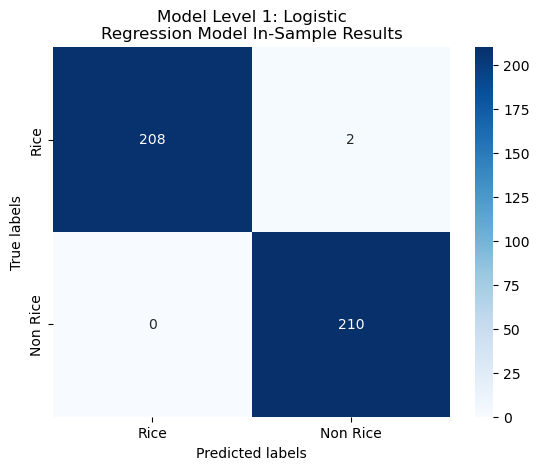

In [306]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

In [307]:
outsample_predictions = model.predict(X_test)

In [309]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        90
        Rice       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



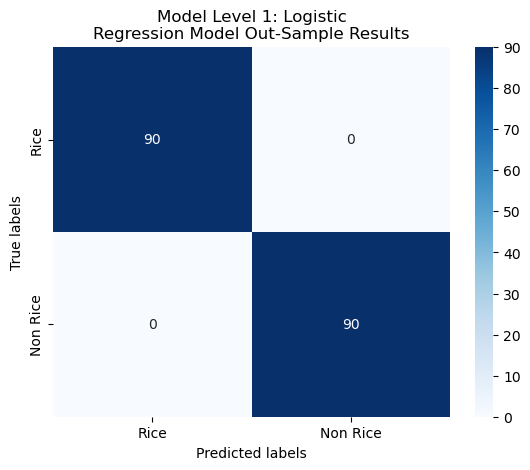

In [310]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

In [59]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()
coordinates=test_file['id']

In [60]:
## Function call to get the data at the harvesting time of September 
time_slice = "2020-9-15/2020-9-15"
test_values = []
for coordinates in tqdm(test_file['id']):
    test_values.append(get_sentinel_data(coordinates,time_slice))


100%|██████████| 250/250 [57:17<00:00, 13.75s/it] 


In [61]:
test_data = pd.DataFrame(test_values,columns =['ndvi','gvi','rvi','ipvi','red','green','ir'])
print(test_data.head(10));

       ndvi       gvi       rvi      ipvi   red  green    ir
0  0.316376  0.249861  1.925587  0.658188  3494   4038  6728
1  0.545100  0.496228  3.396574  0.772550  1518   1736  5156
2  0.445061  0.481229  2.604000  0.722531  1500   1368  3906
3  0.133103  0.113376  1.307079  0.566551  4012   4176  5244
4  0.382506  0.410856  2.238897  0.691253  2612   2442  5848
5  5.983150  0.000373  0.964029  0.490842  5560   5356  5360
6  0.428330  0.417773  2.498520  0.714165  3378   3466  8440
7  0.192077  0.181440  1.475483  0.596038  2692   2752  3972
8  0.133103  0.113376  1.307079  0.566551  4012   4176  5244
9  0.321360  0.323482  1.947070  0.660680  2116   2106  4120


In [62]:
## Function call to get the data at the harvesting time of march
time_slice = "2020-03-15/2020-03-30"
test_values_2 = []
for coordinates in tqdm(test_file['id']):
    test_values_2.append(get_sentinel_data(coordinates,time_slice))


100%|██████████| 250/250 [02:52<00:00,  1.45it/s]


In [63]:
test_data_2 = pd.DataFrame(test_values_2,columns =['ndvi1','gvi1','rvi1','ipvi1','red1','green1','ir1'])
print(test_data_2.head(10));

      ndvi1      gvi1      rvi1     ipvi1  red1  green1   ir1
0       NaN       NaN       NaN       NaN     0       0     0
1  0.383678  0.439341  2.245059  0.691839  2024    1770  4544
2  0.481609  0.520047  2.858093  0.740805  1804    1628  5156
3  0.213043  0.243870  1.541436  0.606522  3620    3392  5580
4       NaN       NaN       NaN       NaN     0       0     0
5  0.034627  0.056218  1.071737  0.517313  4628    4432  4960
6  0.266786  0.267469  1.727718  0.633393  4084    4078  7056
7  0.263631  0.234723  1.716028  0.631815  2296    2442  3940
8  0.213043  0.243870  1.541436  0.606522  3620    3392  5580
9  0.444703  0.430960  2.601677  0.722352  1908    1974  4964


In [64]:
## Function call to get the data at the non harvesting time of September 
time_slice = "2020-04-1/2020-04-1"
test_values_3 = []
for coordinates in tqdm(test_file['id']):
    test_values_3.append(get_sentinel_data(coordinates,time_slice))


100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


In [65]:
test_data_3 = pd.DataFrame(test_values_3,columns =['ndvi2','gvi2','rvi2','ipvi2','red2','green2','ir2'])
print(test_data_3.head(10));

      ndvi2      gvi2      rvi2     ipvi2  red2  green2   ir2
0  0.243562  0.240899  1.643972  0.621781  2820    2836  4636
1  0.232252  0.261355  1.605020  0.616126  3028    2846  4860
2  0.424709  0.461935  2.476503  0.712355  1830    1668  4532
3  0.105613  0.124296  1.236168  0.552806  4844    4664  5988
4  0.264187  0.245253  1.718081  0.632093  2710    2822  4656
5  0.092540  0.118998  1.203953  0.546270  4452    4220  5360
6  0.297340  0.312228  1.846325  0.648670  3592    3476  6632
7  0.151630  0.203653  1.357461  0.575815  3592    3226  4876
8  0.105613  0.124296  1.236168  0.552806  4844    4664  5988
9  0.067431  0.099160  1.144612  0.533715  4232    3970  4844


In [66]:
test_data.info

<bound method DataFrame.info of          ndvi       gvi       rvi      ipvi   red  green    ir
0    0.316376  0.249861  1.925587  0.658188  3494   4038  6728
1    0.545100  0.496228  3.396574  0.772550  1518   1736  5156
2    0.445061  0.481229  2.604000  0.722531  1500   1368  3906
3    0.133103  0.113376  1.307079  0.566551  4012   4176  5244
4    0.382506  0.410856  2.238897  0.691253  2612   2442  5848
..        ...       ...       ...       ...   ...    ...   ...
245  0.023956  0.071337  1.049087  0.511978  6356   5780  6668
246  0.133103  0.113376  1.307079  0.566551  4012   4176  5244
247  0.133103  0.113376  1.307079  0.566551  4012   4176  5244
248  0.317379  0.364414  1.929883  0.658689  2396   2154  4624
249  0.297128  0.282395  1.845468  0.648564  2692   2780  4968

[250 rows x 7 columns]>

In [67]:
def combine_three_datasets(dataset1,dataset2,dataset3):
    data = pd.concat([dataset1,dataset2,dataset3], axis=1)
    return data

In [68]:
test_data_comb = combine_three_datasets(test_data,test_data_2,test_data_3)
test_data_comb.head()

,ndvi,gvi,rvi,ipvi,red,green,ir,ndvi1,gvi1,rvi1,...,red1,green1,ir1,ndvi2,gvi2,rvi2,ipvi2,red2,green2,ir2
0,0.316376,0.249861,1.925587,0.658188,3494,4038,6728,NaN,NaN,NaN,...,0,0,0,0.243562,0.240899,1.643972,0.621781,2820,2836,4636
1,0.545100,0.496228,3.396574,0.772550,1518,1736,5156,0.383678,0.439341,2.245059,...,2024,1770,4544,0.232252,0.261355,1.605020,0.616126,3028,2846,4860
2,0.445061,0.481229,2.604000,0.722531,1500,1368,3906,0.481609,0.520047,2.858093,...,1804,1628,5156,0.424709,0.461935,2.476503,0.712355,1830,1668,4532
3,0.133103,0.113376,1.307079,0.566551,4012,4176,5244,0.213043,0.243870,1.541436,...,3620,3392,5580,0.105613,0.124296,1.236168,0.552806,4844,4664,5988
4,0.382506,0.410856,2.238897,0.691253,2612,2442,5848,NaN,NaN,NaN,...,0,0,0,0.264187,0.245253,1.718081,0.632093,2710,2822,4656


In [69]:
#fill nan values by means
for value in test_data_comb.columns:
    # Replace null values with the mean of the same class
    test_data_comb[value] = test_data_comb[value].fillna(value=0)

In [70]:
# Feature Scaling 
test_values = test_data_comb.values

transformed_submission_data = sc.transform(test_values)

In [71]:
print(transformed_submission_data.size)

5250


In [72]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)


In [73]:
print(final_prediction_series.size)

250


In [74]:
print(test_file['id'].size)

250


In [75]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['id'].values, 'Class of Land':final_prediction_series.values})

In [76]:
submission_df

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [77]:
import csv

In [79]:
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)